In [1]:
import tiktoken
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from gpt_model import GPTModel
from clean_gutenberg_text import clean_gutenberg_text
from train_sae import train_sae
from sparse_auto_encoder import SparseAutoencoder

In [2]:
device = "cpu"

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.2,
    "qkv_bias": True,
    "device": device,
}

In [4]:
model = GPTModel(GPT_CONFIG_124M)
checkpoint = torch.load("model_768_12_12_old_tok.pth", weights_only=True, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval();

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")

In [6]:
sae_6 = SparseAutoencoder(input_dim=768, hidden_dim=3072).to(device)
sae_6.load_state_dict(torch.load("sae_model_6_3072.pth", map_location=torch.device('cpu')))
sae_6.eval();

sae_12 = SparseAutoencoder(input_dim=768, hidden_dim=3072).to(device)
sae_12.load_state_dict(torch.load("sae_model_12_3072.pth", map_location=torch.device('cpu')))
sae_12.eval();

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_gender_bias(model, sae_model, tokenizer, sentences, layer=6, top_k=10, device="cuda"):
    model.to(device)
    sae_model.to(device)
    model.eval()
    sae_model.eval()

    activations_per_topic = {}

    for category, category_sentences in sentences.items():
        all_activations = []

        for sentence in category_sentences:
            encoded = tokenizer.encode(sentence, allowed_special={'<|endoftext|>'})
            encoded_tensor = torch.tensor(encoded).unsqueeze(0)
            
            with torch.no_grad():
                _, hidden_states = model(encoded_tensor, output_hidden_states=True)
                hidden_states = hidden_states[layer - 1]  # Extract layer activations
                
                # Average activations over the sequence dimension
                mean_activation = hidden_states.mean(dim=1)  

                # Pass through SAE
                _, sae_activations = sae_model(mean_activation)

                # Store activations
                all_activations.append(sae_activations.squeeze().cpu().numpy())

        # Compute mean activations across all sentences in the category
        avg_activations = np.mean(np.array(all_activations), axis=0)

        # Get top-k neuron activations
        top_indices = np.argsort(avg_activations)[-top_k:][::-1]
        top_activations = avg_activations[top_indices]

        activations_per_topic[category] = list(zip(top_indices, top_activations))

#     print("Top neuron activations per topic:")
#     for category, activations in activations_per_topic.items():
#         print(f"{category}: {activations}")

    return activations_per_topic


def visualize_categoriacal_activations(activations_per_topic):
    """
    Visualizes neuron activations across topics.

    Args:
        activations_per_topic: Dictionary with topics as keys and top neuron activations as values.
    """
    topics = list(activations_per_topic.keys())
    neuron_ids = {neuron for activations in activations_per_topic.values() for neuron, _ in activations}
    neuron_ids = sorted(neuron_ids)

    # Create a DataFrame for visualization
    data = []
    for topic in topics:
        row = {neuron: 0 for neuron in neuron_ids}
        for neuron, activation in activations_per_topic[topic]:
            row[neuron] = activation
        row["Topic"] = topic
        data.append(row)

    df = pd.DataFrame(data)
    df.set_index("Topic", inplace=True)

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    plt.imshow(df, cmap="viridis", aspect="auto")
    plt.colorbar(label="Activation Strength")
    plt.xticks(ticks=np.arange(len(neuron_ids)), labels=neuron_ids, rotation=90)
    plt.yticks(ticks=np.arange(len(topics)), labels=topics)
    plt.xlabel("Neuron ID")
    plt.ylabel("Topic")
    plt.title("Top Neuron Activations Across Topics")
    plt.show()

In [8]:
import torch
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_gender_neurons(activations_per_topic):
    """
    Identifies neurons uniquely responsible for encoding gender concepts and measures differences.
    Cross-references these neurons with other categories.
    """
    # Extract neuron activations for male and female topics
    male_neurons = set(n for n, _ in activations_per_topic.get("male", []))
    female_neurons = set(n for n, _ in activations_per_topic.get("female", []))
    
    # Find unique neurons for each category
    unique_male_neurons = male_neurons - female_neurons
    unique_female_neurons = female_neurons - male_neurons
    
    # Cross-reference unique gender neurons with other categories
    category_neuron_map = {}
    overlap_counts = defaultdict(lambda: {"unique_male": 0, "unique_female": 0})
    
    for category, activations in activations_per_topic.items():
        if category in ["male", "female"]:
            continue  # Skip gender-specific categories
        
        category_neurons = set(n for n, _ in activations)
        
        # Count overlaps
        overlap_male = unique_male_neurons & category_neurons
        overlap_female = unique_female_neurons & category_neurons
        overlap_counts[category]["unique_male"] = len(overlap_male)
        overlap_counts[category]["unique_female"] = len(overlap_female)
    
    # Convert to DataFrame for visualization
    df_overlap = pd.DataFrame.from_dict(overlap_counts, orient='index')
    df_overlap.reset_index(inplace=True)
    df_overlap.rename(columns={"index": "Category"}, inplace=True)
    
    # Plot
    df_overlap.plot(x="Category", kind="bar", stacked=True, figsize=(10, 6))
    plt.title("Overlap of Unique Gender Neurons with Other Categories")
    plt.xlabel("Category")
    plt.ylabel("Number of Overlapping Neurons")
    plt.legend(title="Neuron Type")
    plt.xticks(rotation=45)
    plt.show()
    
    print("Unique Male Neurons Overlapping Other Categories:")
    for category, counts in overlap_counts.items():
        print(f"{category}: {counts['unique_male']} male neurons, {counts['unique_female']} female neurons")
    
    return overlap_counts

# Example usage
# results = analyze_gender_neurons(bias_results)

In [9]:
with open("theme_bias_analysis.json", "r") as f:
    data = json.load(f)
    
sentences = data

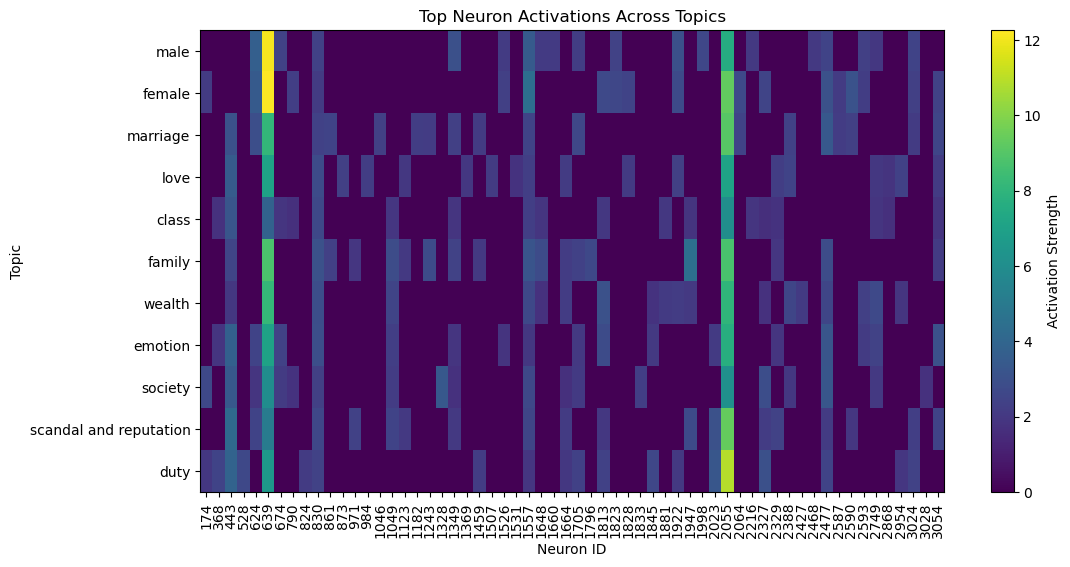

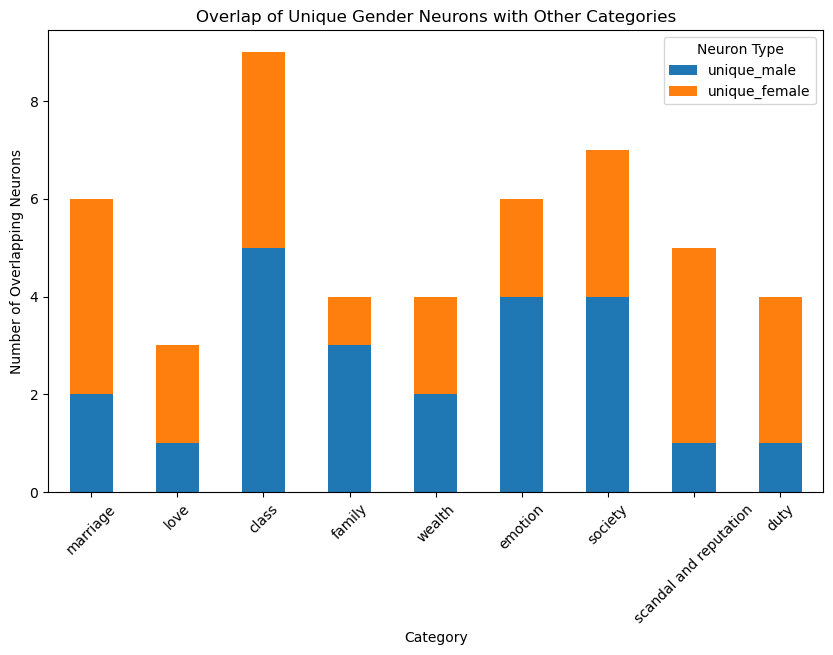

Unique Male Neurons Overlapping Other Categories:
marriage: 2 male neurons, 4 female neurons
love: 1 male neurons, 2 female neurons
class: 5 male neurons, 4 female neurons
family: 3 male neurons, 1 female neurons
wealth: 2 male neurons, 2 female neurons
emotion: 4 male neurons, 2 female neurons
society: 4 male neurons, 3 female neurons
scandal and reputation: 1 male neurons, 4 female neurons
duty: 1 male neurons, 3 female neurons


In [14]:
bias_results = analyze_gender_bias(model, sae_6, tokenizer, sentences, layer=6, top_k=20, device=device)

visualize_categoriacal_activations(bias_results)
analyze_gender_neurons(bias_results);

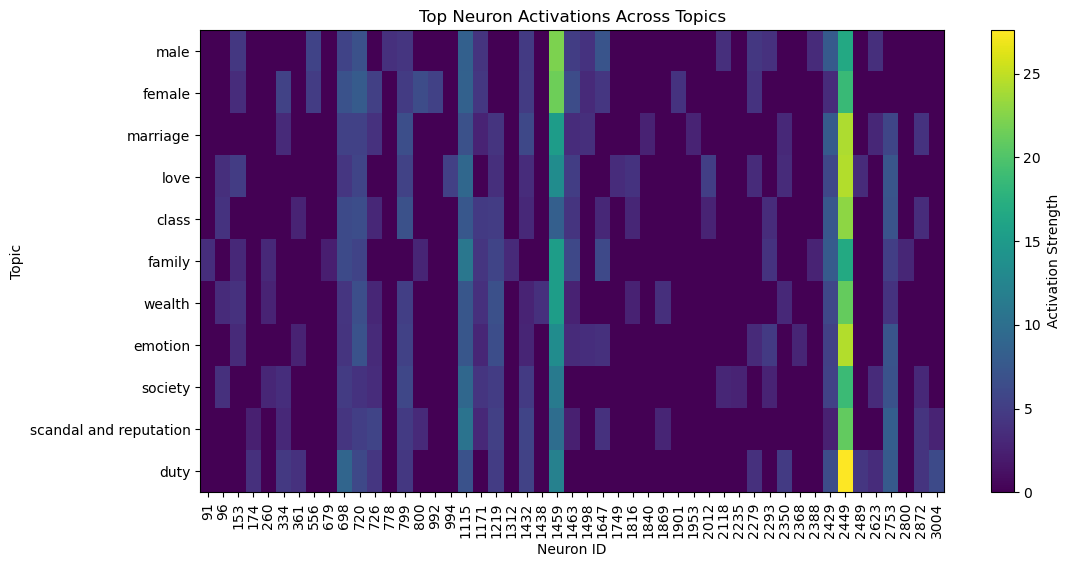

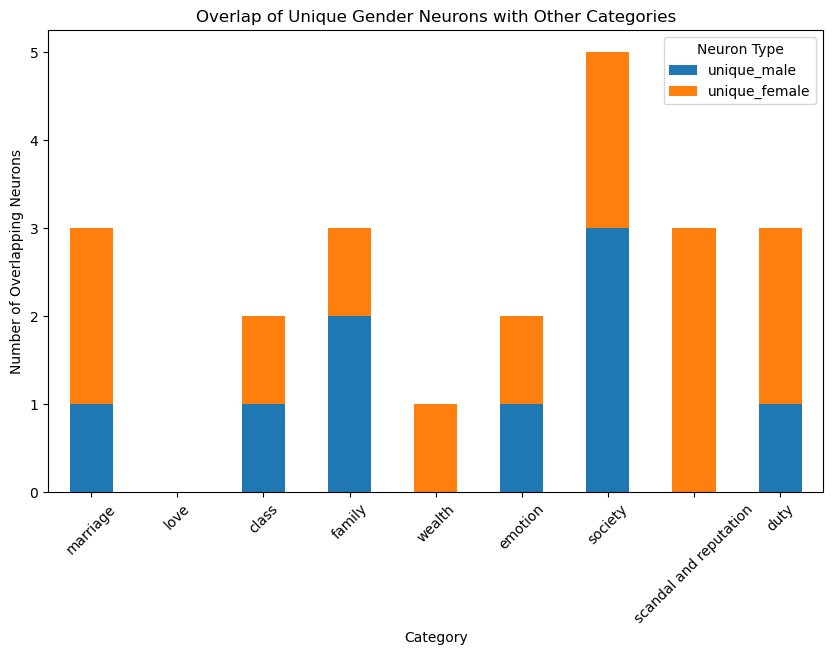

Unique Male Neurons Overlapping Other Categories:
marriage: 1 male neurons, 2 female neurons
love: 0 male neurons, 0 female neurons
class: 1 male neurons, 1 female neurons
family: 2 male neurons, 1 female neurons
wealth: 0 male neurons, 1 female neurons
emotion: 1 male neurons, 1 female neurons
society: 3 male neurons, 2 female neurons
scandal and reputation: 0 male neurons, 3 female neurons
duty: 1 male neurons, 2 female neurons


In [15]:
bias_results = analyze_gender_bias(model, sae_12, tokenizer, sentences, layer=12, top_k=20, device=device)
visualize_categoriacal_activations(bias_results)
analyze_gender_neurons(bias_results);

In [17]:
with open("theme_bias_analysis_words.json", "r") as f:
    data = json.load(f)
    
words = data

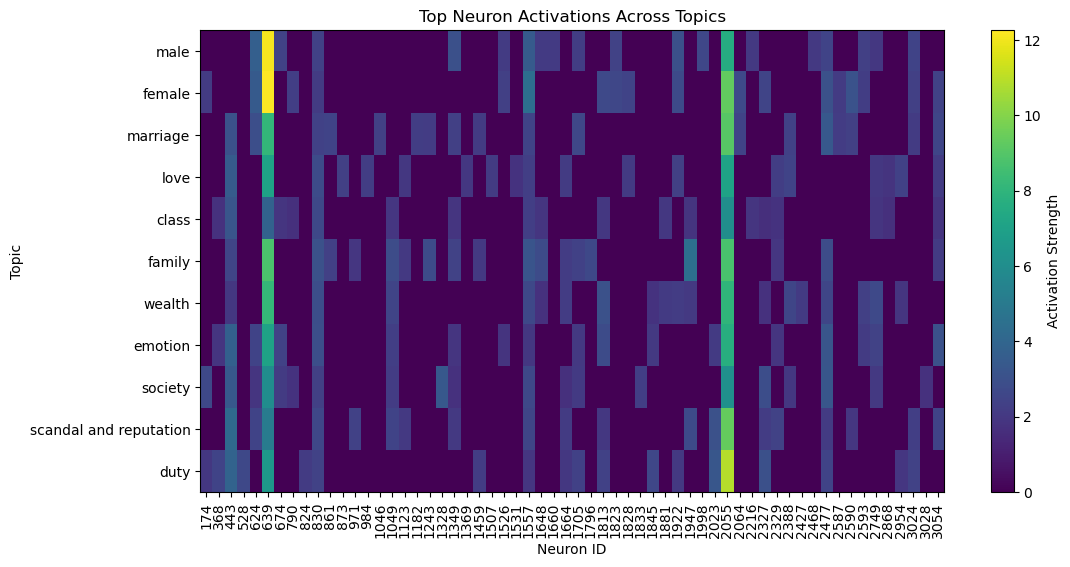

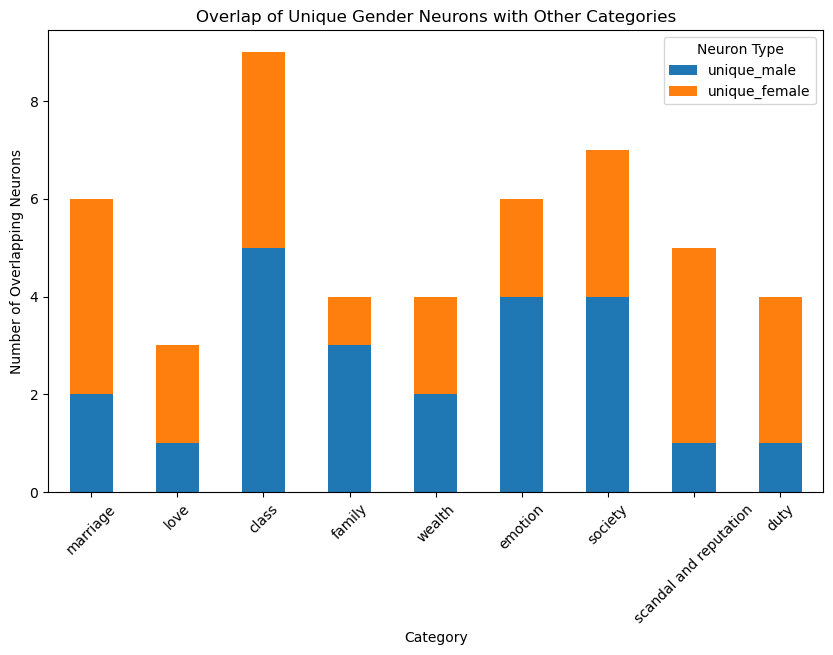

Unique Male Neurons Overlapping Other Categories:
marriage: 2 male neurons, 4 female neurons
love: 1 male neurons, 2 female neurons
class: 5 male neurons, 4 female neurons
family: 3 male neurons, 1 female neurons
wealth: 2 male neurons, 2 female neurons
emotion: 4 male neurons, 2 female neurons
society: 4 male neurons, 3 female neurons
scandal and reputation: 1 male neurons, 4 female neurons
duty: 1 male neurons, 3 female neurons


In [18]:
bias_results = analyze_gender_bias(model, sae_6, tokenizer, words, layer=6, top_k=20, device=device)

visualize_categoriacal_activations(bias_results)
analyze_gender_neurons(bias_results);

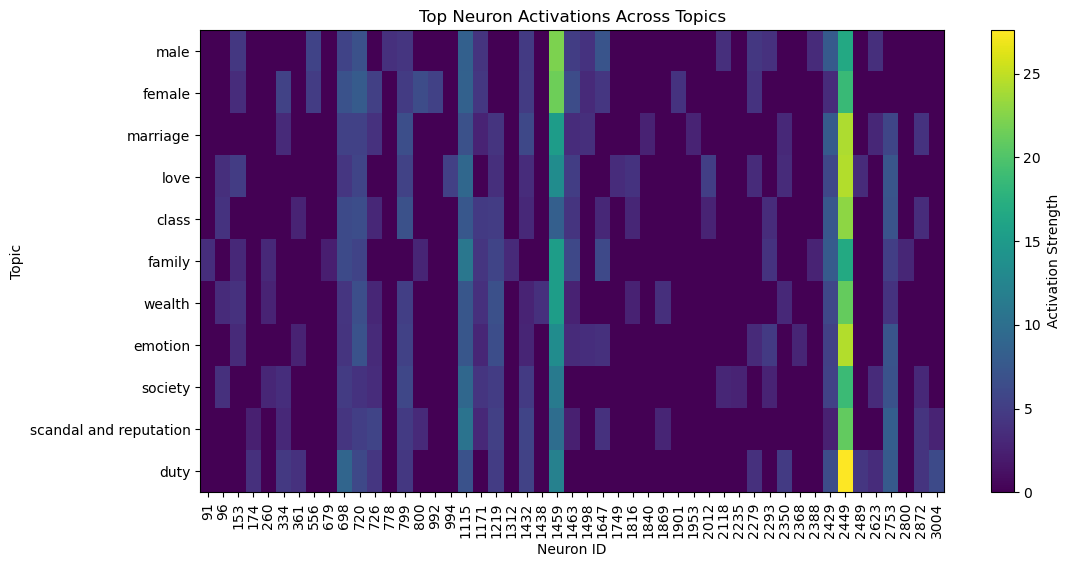

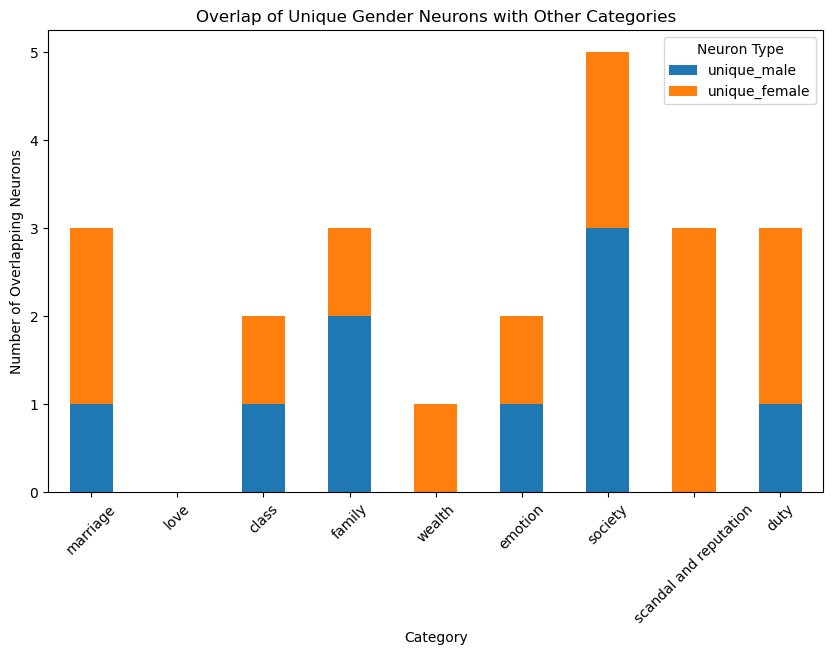

Unique Male Neurons Overlapping Other Categories:
marriage: 1 male neurons, 2 female neurons
love: 0 male neurons, 0 female neurons
class: 1 male neurons, 1 female neurons
family: 2 male neurons, 1 female neurons
wealth: 0 male neurons, 1 female neurons
emotion: 1 male neurons, 1 female neurons
society: 3 male neurons, 2 female neurons
scandal and reputation: 0 male neurons, 3 female neurons
duty: 1 male neurons, 2 female neurons


In [19]:
bias_results = analyze_gender_bias(model, sae_12, tokenizer, words, layer=12, top_k=20, device=device)
visualize_categoriacal_activations(bias_results)
analyze_gender_neurons(bias_results);